In [13]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
data_raw = pd.read_csv("reviews_train.csv")
data_raw.head(5)

,review,sentiment
0,Increment is not good you have to switch in or...,0
1,It depends on the team you are working with. I...,1
2,"Might not be good at hike system, compare to o...",0
3,Less Hike and Les salary,0
4,Onsite opportunity will be minimal,0


In [15]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1911 entries, 0 to 1910
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1911 non-null   object
 1   sentiment  1911 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.0+ KB


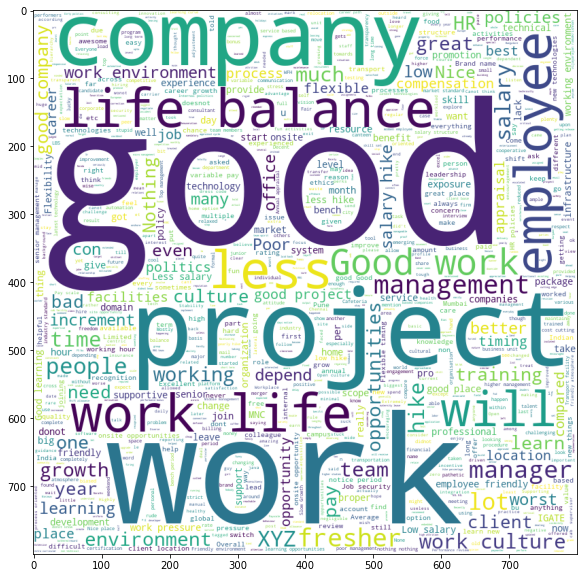

In [16]:
reviews_raw_combined = " ".join(data_raw.review.values)
reviews_raw_combined = reviews_raw_combined.replace("n't", "not")
word_cloud = WordCloud(width=800,height=800,background_color='white',max_words=1500,random_state=1).\
generate_from_text(reviews_raw_combined)

plt.figure(figsize=[10,10])
plt.imshow(word_cloud)

## Inferences
* From above it is clear few general words like 'company', 'XYZ' can be removed.. not adding values.. 

In [17]:
from nltk.tokenize import word_tokenize
all_terms = word_tokenize(reviews_raw_combined.lower())
len(set(all_terms))

3383

<AxesSubplot:xlabel='words'>

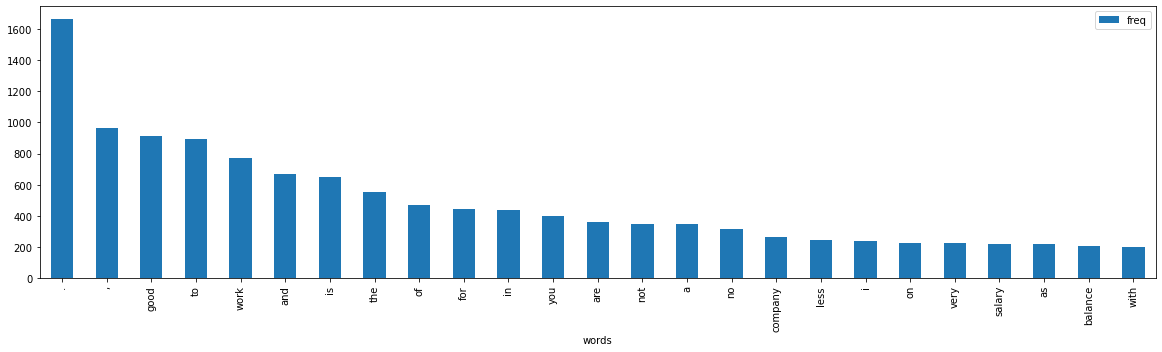

In [18]:
fdist = {}
for word in all_terms:
    fdist[word] = fdist.get(word,0) + 1
freq = {"words":list(fdist.keys()),"freq":list(fdist.values())}
df_dist = pd.DataFrame(freq)
df_dist.sort_values(ascending=False, by="freq").head(25).\
plot.bar(x= "words", y= "freq",figsize=(20,5)) 

In [19]:
## cleaning of data
from string import punctuation
from nltk.corpus import stopwords
stop_nltk = stopwords.words("english")
stop_nltk.remove("not")
stop_nltk.remove("no")
stop_updated = stop_nltk + list(punctuation) + ["..."] +  [".."] + ["company","XYZ"]
#stop_updated

## Attempt to translate french to english

In [ ]:
#!pip install googletrans

In [20]:
# converting french to neglish
from googletrans import Translator

translator = Translator()

def fr_to_eng (text):
    if 'Ã' in text:
       return translator.translate(text, dest='en').text
    else:
       return text

data_raw["fr_to_eng_review"] = data_raw["review"].apply(fr_to_eng)
data_raw.iloc[41:45]

,review,sentiment,fr_to_eng_review
41,"13Ã¨me moi,\r\r\nPrime de la grande fÃªte\r\r\...",1,"13th me,\r\r\nBig Party Bounty\r\r\ntraining\r..."
42,- Flexible work hours (varies from project to ...,1,- Flexible work hours (varies from project to ...
43,less pay and less work.\r\nUsing developer as ...,0,less pay and less work.\r\nUsing developer as ...
44,Performance hike is tooo lessssssss,0,Performance hike is tooo lessssssss


In [21]:
from nltk.corpus import wordnet
import re

from nltk.stem import WordNetLemmatizer


lemm = WordNetLemmatizer()

def  clean_txt_after_lem_new(sent):
    sent_up = re.sub(r"[^\w\s]+"," ",sent)
    tokens = word_tokenize(sent_up.lower())
    
    new_words = []
    temp_word = ''
    for word in tokens:
        antonyms = []
        if word == 'no':
           temp_word = 'not_'
        if word in stop_updated or len(word) <= 2: # ignore word which are stopword list or small work (less < 2)
           continue
        if word == 'not':
           temp_word = 'not_'
        elif word == "n't":
           temp_word = 'not_'
        elif temp_word == 'not_':
           for syn in wordnet.synsets(word):
               for s in syn.lemmas():
                   for a in s.antonyms():
                       antonyms.append(a.name())
           if len(antonyms) >= 1:
              word = antonyms[0]
           else:
              word = temp_word + word
           temp_word = ''
        word = lemm.lemmatize(word,pos='v')
        if word != 'not':
           new_words.append(word)
    
    res = " ".join(new_words)
    return res

In [22]:
data_raw['clean_review_lem_new'] = data_raw.fr_to_eng_review.apply(clean_txt_after_lem_new)
#data_raw.iloc[75].values,
#data_raw.iloc[40:45]

#### Plot the bar graph for top 25 frequenctly used bigrams for postive sentiment

C:\Users\pandatu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:>

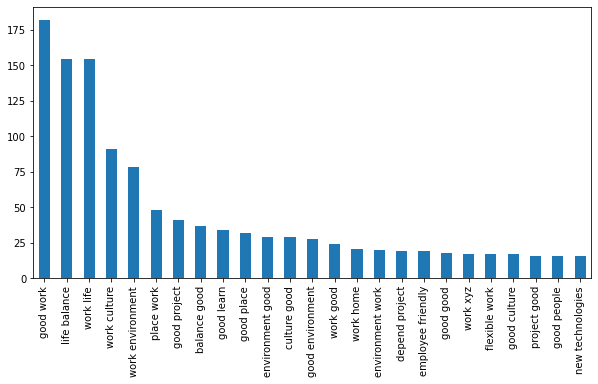

In [24]:
bigram_count_vectorizer = CountVectorizer(ngram_range=(2,2),max_features = 1000)
X_bigram = bigram_count_vectorizer.fit_transform(data_raw.loc[data_raw['sentiment'] == 1]['clean_review_lem_new'])

# Creating a DTM
DTM_bigram = pd.DataFrame(X_bigram.toarray(), columns=bigram_count_vectorizer.get_feature_names())
DTM_bigram.sum().sort_values(ascending=False).head(25).plot.bar(figsize=(10,5))

In [25]:
k = DTM_bigram.sum().sort_values(ascending=False)
k.head(20)

good work            182
life balance         154
work life            154
work culture          91
work environment      78
place work            48
good project          41
balance good          37
good learn            34
good place            32
environment good      29
culture good          29
good environment      28
work good             24
work home             21
environment work      20
depend project        19
employee friendly     19
good good             18
work xyz              17
dtype: int64

In [27]:
Co_Infra = ['good work','place work', 'good place']
Benefit = ['good learn','depend project','work environment','new technologies']
Culture = ['good work','work life','life balance','work culture','balance good','environment good','culture good', 'work good','work home', 'environment work','employee friendly','company good']
Good_work = ['good project','project good']
Others = ['notice period','others']

def identify_group(entry):
    for i in Co_Infra:
        if i in entry:
           return "Co_infra"
    for i in Benefit:
        if i in entry:
            return "Benefit"
    for i in Culture:
        if i in entry:
            return "Culture"
    for i in Good_work:
        if i in entry:
            return "Good_work"     
    return "Others"

data_raw['Pos_categorization_bi'] = data_raw.clean_review_lem_new.apply(identify_group)

                       clean_review_lem_new
Pos_categorization_bi                      
Benefit                                 106
Co_infra                                236
Culture                                 211
Good_work                                32
Others                                 1326


<AxesSubplot:xlabel='Pos_categorization_bi'>

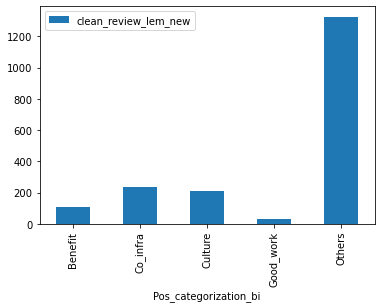

In [89]:
freq = data_raw[['Pos_categorization_bi','clean_review_lem_new']].groupby(['Pos_categorization_bi']).count()
print(freq)
freq.plot.bar()

## NGram analysis for negative sentiment

C:\Users\pandatu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:>

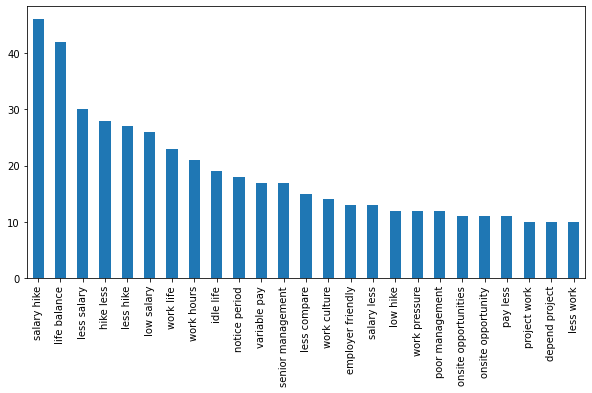

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_count_vectorizer = CountVectorizer(ngram_range=(2,2),max_features = 100)
X_bigram = bigram_count_vectorizer.fit_transform(data_raw.loc[data_raw['sentiment'] == 0]['clean_review_lem_new'])

# Creating a DTM
DTM_bigram = pd.DataFrame(X_bigram.toarray(), columns=bigram_count_vectorizer.get_feature_names())
DTM_bigram.sum().sort_values(ascending=False).head(25).plot.bar(figsize=(10,5))

In [29]:
k3 = DTM_bigram.sum().sort_values(ascending=False)
k3.head(20)

salary hike             46
life balance            42
less salary             30
hike less               28
less hike               27
low salary              26
work life               23
work hours              21
idle life               19
notice period           18
variable pay            17
senior management       17
less compare            15
work culture            14
employer friendly       13
salary less             13
low hike                12
work pressure           12
poor management         12
onsite opportunities    11
dtype: int64

In [31]:
Work_culture = ['notice period','life balance','work life','work hours','idle life','work culture','work pressure']
salary_issues = ['salary hike','hike less','less hike','low hike','pay less','less salary','low salary','variable pay','less compare','salary less']
Management_issues = ['poor management','senior management','employer friendly']
Others = ['others','notice period']

def identify_group(entry1):
    for i in salary_issues:
        if i in entry1:
           return "salary_issues"
    for i in Work_culture:
        if i in entry1:
            return "Work_culture"
    for i in Management_issues:
        if i in entry1:
            return "Management_issues"     
    return "Others"

data_raw['Pos_categorization_bi_neg'] = data_raw.clean_review_lem_new.apply(identify_group)

<AxesSubplot:xlabel='Pos_categorization_bi_neg'>

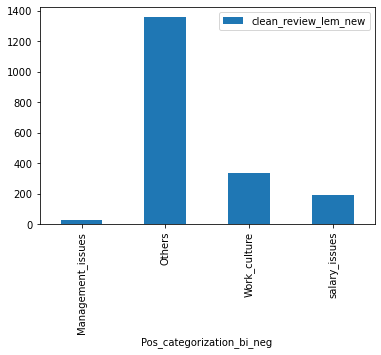

In [32]:
freq = data_raw[['Pos_categorization_bi_neg','clean_review_lem_new']].groupby(['Pos_categorization_bi_neg']).count()
freq.plot.bar()

## Vader Score based predictions
  * Alternative approach to find sentiment if it is not provided

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def get_vader_sentiment(sent):
    return analyser.polarity_scores(sent)['compound']

In [35]:
data_raw['score_vader'] = data_raw.clean_review_lem_new.apply(get_vader_sentiment)
#data_raw['pred_sentiment'] = data_raw.score_vader.apply(lambda x:1 if x>0 else 0)
#data_raw.head(5)
data_raw.drop(['Pos_categorization_bi','Pos_categorization_bi_neg'], axis=1, inplace=True)
data_raw.iloc[282:300]

,review,sentiment,fr_to_eng_review,clean_review_lem_new,score_vader
282,No proper increments as company is investing i...,0,No proper increments as company is investing i...,improper increments invest infrastructure pay ...,-0.1935
283,Much less projects to work in or learn somethi...,0,Much less projects to work in or learn somethi...,much less project work learn something productive,0.0000
284,No Pros nothing will go in you favor,1,No Pros nothing will go in you favor,amateur nothing favor,-0.3089
285,"you need maintain time effectively, time sheet...",0,"you need maintain time effectively, time sheet...",need maintain time effectively time sheet imp,0.4404
286,Some projects gives good work life balance; bu...,1,Some projects gives good work life balance; bu...,project give good work life balance cost loose...,0.1531
287,Relocation is one of the biggest issue in most...,0,Relocation is one of the biggest issue in most...,relocation one biggest issue firm especially p...,-0.1761
288,everything is a con\r\r\npoor salatry\r\r\npoo...,0,everything is a con\r\r\npoor salatry\r\r\npoo...,everything con poor salatry poor hryou lacs em...,-0.7410
289,If you want to Promotion than need to wait at ...,0,If you want to Promotion than need to wait at ...,want promotion need wait least years site oppo...,0.4767
290,1. Poor work life balance\r\r\n2. Not employe...,0,1. Poor work life balance\r\r\n2. Not employe...,poor work life balance employer centric manage...,-0.7430
291,Too many of them actually.\r\n\r\n1) Very low ...,0,Too many of them actually.\r\n\r\n1) Very low ...,many actually low salary compare market typica...,0.7096


In [106]:
data_raw.sentiment.value_counts()

1    956
0    955
Name: sentiment, dtype: int64

In [107]:
data_raw.score_vader.describe()

count    1911.000000
mean        0.241398
std         0.475865
min        -0.943200
25%         0.000000
50%         0.361200
75%         0.670500
max         0.976600
Name: score_vader, dtype: float64

In [36]:
data_raw['pred_sentiment'] = data_raw.score_vader.apply(lambda x:1 if x>0.5 else 0)
data_raw.head(5)

,review,sentiment,fr_to_eng_review,clean_review_lem_new,score_vader,pred_sentiment
0,Increment is not good you have to switch in or...,0,Increment is not good you have to switch in or...,increment evil switch order get good hike salary,-0.3612,0
1,It depends on the team you are working with. I...,1,It depends on the team you are working with. I...,depend team work work good team,0.4404,0
2,"Might not be good at hike system, compare to o...",0,"Might not be good at hike system, compare to o...",might evil hike system compare world leaders t...,-0.6597,0
3,Less Hike and Les salary,0,Less Hike and Les salary,less hike les salary,0.0000,0
4,Onsite opportunity will be minimal,0,Onsite opportunity will be minimal,onsite opportunity minimal,0.4215,0
